In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from copy import deepcopy
import scipy
np.random.seed(1)

In [3]:

# print(bp104_1)
# print(bp104_2)
# print(bp104_3)
# print(bp104_4)

#             for i in range (len(measurments)):
#                 like_ = scipy.stats.norm.pdf(z_t[i], measurments[i][0].flatten(), measurments[i][1].flatten())
#                 likelihood*=like_

In [4]:
'''
create_singular_model: if True will creaet 
'''
class MeasurmentModel:
    def __init__(self, map_, bp104s, normed_consts, var_const = 1, create_singular_model = False):
        self.map_ = map_
        self.bp104_1, self.bp104_2, self.bp104_3, self.bp104_3 = bp104s 
        self.normed_consts = normed_consts
        self.gp_models = None
        self.var_const = var_const
        self.kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        self.create_singular_model = create_singular_model
        self.bp104_1_loc = [0.5, 2.5]
        self.bp104_2_loc = [16.5,9.5]
        self.bp104_3_loc = [18.5,2.5]
        self.bp104_4_loc = [10.5,4.5]
        
        if self.create_singular_model:
            # create one model for all beacons
            print("Creating one gp model for all beacons.")
            self.gp_models = self._create_singular_gp_model()
        else:
            # Create four models - one per beacon
            print("Creating four gp model for each beacons.")
            self.gp_models = []
            self._create_four_gp_models()
            
    """
    Function gets liklihood of observing z_t at state_t based on the 
    GP regression model 
    z_t: actual measurment at time t
    state_t: state of the particle at time t
    """
    def get_likelihood(self, z_t, state_t):
        if self.create_singular_model:
            mu, sigma = self.predict(state_t)
            l1, l2, l3, l4 = scipy.stats.norm.pdf(z_t, mu.flatten(), sigma.flatten())
            likelihood = l1 * l2 * l3 * l4
            if likelihood == 0:
                return 1.e-300
            else:
                print('final_likelihood', likelihood)
                return likelihood
        else:
            measurments = self.predict(state_t)
            likelihood = 1.0
            likelihood_ = scipy.stats.norm.pdf(z_t, measurments[:,0], np.diag(measurments[:,1]))
            for i in range (likelihood_.shape[0]):
                likelihood = likelihood *  likelihood_[i,i]
            if likelihood == 0:
                return 1.e-300 # avoid norm. problems
            else:
                return likelihood
        
    def predict(self, state):
        if self.create_singular_model:
            mu, sigma = self.gp_models.predict([[state[0], state[1]]], return_cov=True)
            return [mu, sigma]
        else:
            measurment = []
            for i in range(len(self.gp_models)):
                mu, sigma = self.gp_models[i].predict([[state[0], state[1]]], return_cov=True)
                measurment.append(np.array([mu.flatten()[0], sigma.flatten()[0]]))
            return np.array(measurment)

    def _get_beacon_dists(self, state):
        bp104_1_dist = np.sqrt((state[0]-self.bp104_1_loc[0])**2 + (state[1] - self.bp104_1_loc[1])**2)
        bp104_2_dist = np.sqrt((state[0]-self.bp104_2_loc[0])**2 + (state[1] - self.bp104_2_loc[1])**2)
        bp104_3_dist = np.sqrt((state[0]-self.bp104_3_loc[0])**2 + (state[1] - self.bp104_3_loc[1])**2)
        bp104_4_dist = np.sqrt((state[0]-self.bp104_4_loc[0])**2 + (state[1] - self.bp104_4_loc[1])**2)

        dist_arr = np.array([bp104_1_dist, bp104_2_dist, bp104_3_dist, bp104_4_dist])
        dist_arr = 1./dist_arr
        normed_dist_arr = dist_arr / np.sum(dist_arr)
        return normed_dist_arr
    
    def _create_four_gp_models(self):
        self.gp_models.append(self._create_one_beacon_model(bp104_1))
        self.gp_models.append(self._create_one_beacon_model(bp104_2))
        self.gp_models.append(self._create_one_beacon_model(bp104_3))
        self.gp_models.append(self._create_one_beacon_model(bp104_4))
        print("Created 4 GP models")
        
    def _create_singular_gp_model(self):
        for i in range (bp104_1.shape[0]):
            for j in range (bp104_1.shape[1]):    
                X.append(np.array([i,j])) # just the state [0,0], [0,1] etc... 
                y.append(np.array([bp104_1[i,j], bp104_2[i,j], bp104_3[i,j], bp104_4[i,j]]))
        X= np.array(X)
        y= np.array(y)
        dy = np.random.random(y.shape) * self.var_const
        # Instantiate a Gaussian Process model
        gp = GaussianProcessRegressor(kernel=self.kernel,normalize_y= True, alpha = dy,
                                      n_restarts_optimizer=10)
        
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(X,y)
        return gp
    
    def _create_one_beacon_model(self, bp104_x):
        X = []
        y = []
        for i in range (bp104_x.shape[0]):
            for j in range (bp104_x.shape[1]):    
                X.append(np.array([i,j])) # just the state [0,0], [0,1] etc... 
                y.append(bp104_x[i,j])

        X= np.array(X)
        y= np.array(y)
        dy = np.random.random(y.shape)* self.var_const
        # Instantiate a Gaussian Process model
        gp_bp104x = GaussianProcessRegressor(kernel=self.kernel, alpha=dy,normalize_y= True,
                                      n_restarts_optimizer=10)

        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp_bp104x.fit(X,y)
        return gp_bp104x 
    
    def get_normalized_values(self, measurment):
        #measurment should be four values 
        return np.array(measurment) - np.array(self.normed_consts)

In [5]:
class ParticleFilter:
    def __init__(self, map_, numParticles, measurment_model, grid_size = [27,14], start_position= [0,4], 
                             motionNoise = [2.75, 1.25], sim_measurments=None, movement_offset = 3.0):
        self.map_ = map_
        self.numParticles = numParticles
        self.measurment_model = measurment_model
        self.start_position = start_position
        self.grid_size = grid_size
        self.particles_shape = [numParticles,2]
        self.weights = None 
        self.prev_estimate = []
        self.u_t = [0]
        self.curr_position = start_position
        self.sim_measurments = sim_measurments
        self.simulated_idx = 0 
        self.apriori_adjustment = [False]
        self.movement_offset = movement_offset
        ####################### define constants 
        self.motion_noise = motionNoise # tested over many iterations.
        self.thres_bp104_1 = -10
        self.thres_bp104_2 = -10
        self.thres_bp104_3 = -10
        self.thres_bp104_4 = -8
        #######################
        # initialize particles around start position
#         self.particles = np.random.uniform(0, self.grid_size, self.particles_shape) 
        self.particles = np.random.normal(loc=start_position, scale=[2.0,1.5], size=self.particles_shape) 
        self.particles = self._check_particles_dimensions(self.particles)
    """
    Note: sets the self.particles variables.
    """
    def Sample_motion_model(self, normed_z_t= None, u_t= 0):
        newParticles = []
        ## TODO
        # for each particle point, simulate their next position given the current control
        if normed_z_t is not None:
            change_priori, new_center = self._check_apriori_estimate(normed_z_t)
            # we want to use this apriori calculation most of the time... 
        else: 
            change_priori = False
        if change_priori and (self.apriori_adjustment[-1] == False):
            self.apriori_adjustment.append(True)
            new_particles = self._center_new_particles(new_center)
            newParticles = self._check_particles_dimensions(self.particles) ####
            self.particles = new_particles
        else:
            self.apriori_adjustment.append(False)
            newParticles = np.array([self._simulateNextPosition(x, u_t) for x in self.particles])
            newParticles = self._check_particles_dimensions(self.particles) ####
            self.particles = newParticles
        ####
        
    ##### NOTE:::: CURRENTLY HARD CODED. 
    def _check_particles_dimensions(self, particles):
        a= True 
        if a: 
            for i in range (len(particles)):
                x,y = particles[i]
                if x < 0:
                    while(particles[i][0] < 0):
                        particles[i][0]+=1
                if x > 27:
                    while(particles[i][0] > 27):
                        particles[i][0]-=1
                if y < 0:
                    while(particles[i][1] < 0):
                        particles[i][1]+=1
                if y > 27:
                    while(particles[i][1] > 14):
                        particles[i][1]-=1
            return particles
        else:
            return particles
    #########################  NOTE:::: CURRENTLY HARD CODED. 

    def Sample_measurment_model(self, normed_z_t= None):
        if normed_z_t is None:
            print("Collecting measurment from Sample_measurment Function")
            normed_z_t = self.get_z_t(0)
        if self.apriori_adjustment[-1] == False:
            weights = np.array([self.measurment_model.get_likelihood(normed_z_t, x) for x in self.particles])
            norm_weights = weights / np.sum(weights)
            return norm_weights
        else:
            print("Resetting weights to uniform dist.")
            weights = np.ones(self.numParticles, dtype=float) / self.numParticles
            return weights

    def get_z_t(self, keyboard = 0):
        if keyboard == 1:
            bp104_1 = float(input("bp104_1"))
            bp104_2 = float(input("bp104_2"))
            bp104_3 = float(input("bp104_3"))
            bp104_4 = float(input("bp104_4"))
            return self.measurment_model.get_normalized_values([bp104_1, bp104_2, bp104_3, bp104_4])
        elif keyboard == 0 :
            idx = int(input("Type keyboard index: "))
            bp104_1, bp104_2, bp104_3, bp104_4 = self.measurment_model.get_normalized_values(
                                                    simulated_measurments[idx])
        elif keyboard == 2:
            bp104_1, bp104_2, bp104_3, bp104_4 = self.measurment_model.get_normalized_values(
                                                    self.sim_measurments[self.simulated_idx])
            self.simulated_idx+=1
            return np.array([float(bp104_1), float(bp104_2), float(bp104_3), float(bp104_4)])
    
    def calc_position(self):
        position = self.weights @ self.particles
        self.prev_estimate.append(self.curr_position)
        
        #######################################################
        if self._permissibility(position):
            #position = np.mean(self.particles,axis=0)
            self.curr_position = position
        else:
            #position = np.mean(self.particles,axis=0)
            temp_particles = [[position[0], position[1]]]
            position = self._check_particles_dimensions(temp_particles)[0]
            self.curr_position = position
        #######################################################
    
        ##### Since we resampled the particles with the new space, we cannot use prior info anymore!!!
        if self.apriori_adjustment[-1] == True:
            self.u_t.append([0,0])
            return position[0], position[1] ## return position for now ::::
        #####
        
        u_t = [position[0]-self.prev_estimate[-1][0], position[1]-self.prev_estimate[-1][1]]
        print('UT::: ', u_t)
        
        ######
        # perform some checks to see if the new estimate makes sense compared to previous estimates. 
        #####
        
        ######
        ## it takes a lot for the estimate to shift laterally vs. up or down..
        ######
        if u_t[1] > 1.0: #and u_t[1]-u_t[0] > 2 and u_t[1]-u_t[0] < 6: # the estimate has shifted very right 
            print("Going RIGHT", u_t[1])
            control = 2 ## RIGHT
            dt = u_t[1]

        elif u_t[1] < -1.00: #and u_t[1]-u_t[0] > 2 and u_t[1]-u_t[0] < 6: # the estimate has shifted very right 
            print("Going LEFT", u_t[1])
            control = 3 ## left
            dt = u_t[1]
            

        elif (u_t[0] > 0.10): 
            # the estimate has shifted DOWN 
            print("Going DOWN", u_t[0])
            control = 1 ## DOWN
            dt = u_t[0]
            
        elif u_t[0] < -0.30 and u_t[0]-u_t[1] > 2 and (u_t[0]-u_t[1] < 6): # the estimate has shifted UP 
            print("Going UP", u_t[0])
            control = 4 ## UP
            dt = u_t[0]
            
        else : 
            print("HALTING")
            control = 0 ## HALT
            dt = 0
        self.u_t.append([control,dt])
        
        return position[0], position[1] ## return position for now ::::
    
    def _resampling(self):
        print("Resampling")
        weighted_choices = np.random.choice(len(self.particles), len(self.particles), p=self.weights)
        newParticles = self.particles[weighted_choices]
        newParticles = self._check_particles_dimensions(self.particles) ####

        self.particles = newParticles  
        
    def _low_variance_resampling(self, particles, weights):
        """
        low variance re-sampling
        """

        Neff = 1.0 / (particles.dot(particles.T))[0, 0]  # Effective particle number
        if Neff < (self.numParticles / 2.0):
            print("Performing low_variance_resampling")
            wcum = np.cumsum(weights)
            base = np.cumsum(weights * 0.0 + 1 / self.numParticles) - 1 / self.numParticles
            resampleid = base + np.random.rand(base.shape[0]) / self.numParticles

            inds = []
            ind = 0
            for ip in range(self.numParticles):
                while resampleid[ip] > wcum[ind]:
                    ind += 1
                inds.append(ind)
            new_particles = particles[inds]
            new_weights = np.zeros((1, self.numParticles)) + 1.0 / self.numParticles  # init weight
#         print(new_particles, new_weights)
        print('new_particles, new_weights', new_particles.shape, new_weights.shape)
        return new_particles, new_weights.flatten()
        
    def _simulateNextPosition(self, prev_estimate, u_t_tuple):
        x, y = prev_estimate[0], prev_estimate[1]
        u_t, dt = u_t_tuple
        
        if abs(dt) < 1 and u_t == 1:
            dt*=self.movement_offset
        elif abs(dt) > 1 and u_t == 1 :
            dt*=(self.movement_offset/2)
            
        if u_t == 0: 
            ## HALT
#             print("control: HALT")
            x += np.random.normal(0, self.motion_noise[0])
            y += np.random.normal(0, self.motion_noise[1])
        if u_t == 1: 
            ## DOWN
#             print("control: DOWN")
            x = x + (dt) + np.random.normal(0, self.motion_noise[0])
            y += np.random.normal(0, self.motion_noise[1])
        if u_t == 2: 
#             print("control: RIGHT")
            ## RIGHT
            x += np.random.normal(0, self.motion_noise[1])
            y = y + (dt) + np.random.normal(0, self.motion_noise[0])
        if u_t == 3: 
            ## LEFT
#             print("control: LEFT")
            x += np.random.normal(0, self.motion_noise[1])
            y = y + (dt) - np.random.normal(0, self.motion_noise[0])
        if u_t == 4: 
            ## UP
#             print("control: UP")
            x = x + (dt) - np.random.normal(0, self.motion_noise[0])
            y += np.random.normal(0, self.motion_noise[1])
            
        next_estimate = np.array(x,y)
        return next_estimate
            
    # this method will be correct most of the time because of the way the values are distributed.
    def _check_apriori_estimate(self, normed_z_t):
        if normed_z_t[0] >= self.thres_bp104_1:
            print("bp104_1 case matched", normed_z_t[0])
            return True, [1.0,3.5]

        if normed_z_t[1] >= self.thres_bp104_2:
            print("bp104_2 case matched", normed_z_t[1])
            return True, [18.5,10.0]

        if normed_z_t[2] >= self.thres_bp104_3:
            print("bp104_3 case matched", normed_z_t[2])
            return True, [19.0,5.5]

        if normed_z_t[3] >= self.thres_bp104_4:
            print("bp104_4 case matched", normed_z_t[3])
            return True, [9.5,5.5]
        ## if none of these conditions are met
        return False, None
    
    def _center_new_particles(self, new_center):
        print("_center_new_particles with a new center", new_center)
        new_particles = np.random.normal(loc=new_center, scale=[3.0,2.0], size= self.particles_shape) 
        return new_particles

    """
    get only permissible particles on the map. 
    """
    def _filter_permissible_particles(self):
        for i in range(len(self.particles)):
            if not self._permissibility(self.particles[i]):
                pass
    def _get_straight_line(self, pt1, pt2):
        np.polyfit(pt1, pt2)
    """
    define if a position is permissible according to the map. 
    """
    def _permissibility(self, position):
        a,b= np.where(self.map_ == 1)
        x,y = position
        if x in a and y in b:
            return False
    def plotParticles(self, particles,t):
        new_map_ = np.zeros_like(self.map_)
        new_map_ = np.zeros([27, 14])
        for i in range(len(particles)): 
            x,y = particles[i]
#             if x < 0:
#                 x = 27.-x
#             if y < 0:
#                 y = 14.-y
#             new_map_[int(x)%50, int(y)%50] = 1.
#             new_map_[int(x), int(y)] = 1.
            new_map_[int(x)%27, int(y)%14] = 1.
            
        plt.figure(); plt.imshow(new_map_);plt.title("Particles at time {}".format(t))
        
    def run_particle_filter(self, N, control = 0):
        weights_history = []
        particle_history = []
        z_history = []
        position_history = []
        position_history.append(self.start_position)
        print('position_history', position_history)
        for t in range(N):
            print("------------------------------ at time step", t)
            print("Get measurments:")
            normed_z_t = self.get_z_t(2)
            z_history.append(normed_z_t)    
            #if not the initial round, generate new samples
            if (t > 0):
                self.Sample_motion_model(normed_z_t=normed_z_t, u_t = self.u_t[-1])
            if t == 0 :
                self.plotParticles(self.particles, 0)
                
            #assign weights to each particles
            self.weights = self.Sample_measurment_model(normed_z_t)
#             print('weights:::', self.weights, np.sum(self.weights))
            weights_history.append(self.weights)
                       
            #plot particles
            self.plotParticles(self.particles, t)
            particle_history.append(self.particles)
                       
            #estimate current position
            estimatePosition = self.calc_position()
            position_history.append(estimatePosition)
            print('estimatePosition', estimatePosition)
            
            #resample the particles if number of effective particles is small
            ## Resampling messes it up!
            if self.apriori_adjustment[-1] == False:
#                 self._resampling()          
                self.particles, self.weights = self._low_variance_resampling(self.particles, self.weights)
    
        return weights_history, particle_history, z_history, position_history, self.apriori_adjustment, self.u_t

In [6]:
map_ = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/map_binary_.npy")
bp104_1 = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/bp104_1.npy")
bp104_2 = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/bp104_2.npy")
bp104_3 = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/bp104_3.npy")
bp104_4 = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/bp104_4.npy")
norm_constants = np.load("/Users/kushagratiwary/Documents/ECE445/map_data/final_041719_0112/norm_constants.npy")


measurments = [
    [-51.,-80.,-66.,-62.],
    [-53.,-80.,-67.,-62.],

    [-57.,-80.,-62.,-58.],
    [-57.,-76.,-64.,-56],
    
    [-59.,-66.,-61.,-55.],
    [-59.,-63.,-63.,-54.],
    
    [-62.,-59.,-61.,-56.],
    [-61.,-60.,-54.,-58.],
    
    [-66.,-59.,-57.,-61.],
    [-65.,-56.,-53.,-63.],
    
    [-68.,-52.,-56.,-62.],
    [-70.,-53.,-55.,-64.],

    [-75.,-57.,-57.,-66.],
    [-75.,-60.,-63.,-68.],

    [-72.,-61.,-65.,-68.],
    [-75.,-59.,-63.,-68.]]


simulated_measurments = np.array(measurments).astype(float)
print(norm_constants)
np.seterr(divide='ignore', invalid='ignore')

[-41 -44 -44 -46]


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
GP_measurment_model = MeasurmentModel(map_, np.array([bp104_1, bp104_2, bp104_3, bp104_4]), 
                                      norm_constants, var_const = 3)

Creating four gp model for each beacons.
Created 4 GP models


position_history [[0, 4]]
------------------------------ at time step 0
Get measurments:
UT:::  [0.8677466198955501, 0.6869942112352714]
Going DOWN 0.8677466198955501
estimatePosition (0.8677466198955501, 4.686994211235271)
Performing low_variance_resampling
new_particles, new_weights (800, 2) (1, 800)
------------------------------ at time step 1
Get measurments:
UT:::  [-0.16052175013392544, 0.08471739631042752]
HALTING
estimatePosition (0.7072248697616247, 4.771711607545699)
Performing low_variance_resampling
new_particles, new_weights (800, 2) (1, 800)
------------------------------ at time step 2
Get measurments:
UT:::  [1.0135464907793552, -1.1088484484620853]
Going LEFT -1.1088484484620853
estimatePosition (1.7207713605409798, 3.6628631590836136)
Performing low_variance_resampling
new_particles, new_weights (800, 2) (1, 800)
------------------------------ at time step 3
Get measurments:
UT:::  [0.5205659651370027, -0.4320153088303802]
Going DOWN 0.5205659651370027
estimatePositi

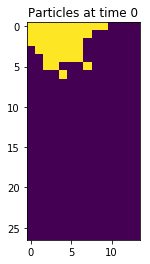

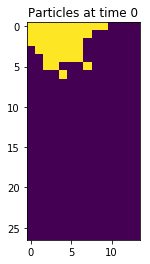

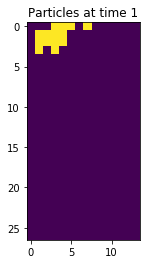

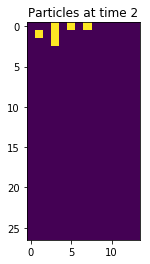

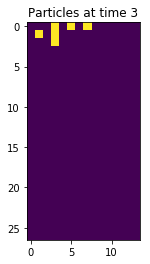

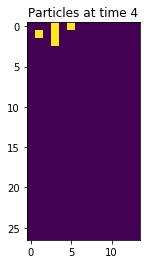

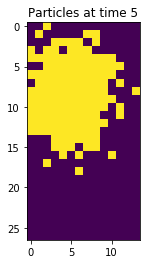

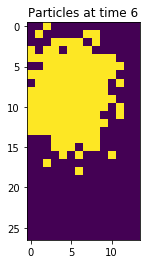

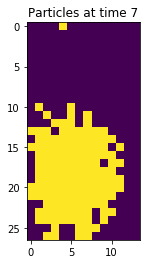

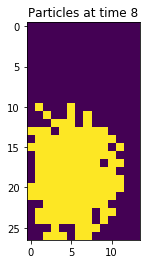

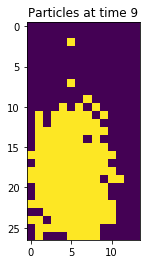

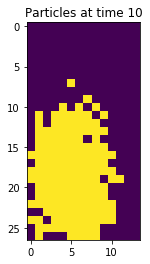

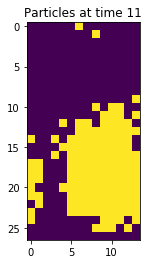

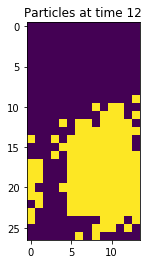

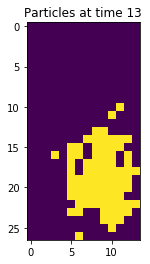

In [8]:
Particle_filter = ParticleFilter(map_, 800, GP_measurment_model, grid_size = [27,14], start_position= [0,4], 
                                 motionNoise=[2.75, 1.25], sim_measurments= measurments, movement_offset = 10.0)
weights_history, particle_history, z_history, position_history, apriori_adjustment, u_t_pf_hist \
                    = Particle_filter.run_particle_filter(14)

In [9]:
[print ('position_history',i-1, position_history[i]) for i in range (len(position_history))]
print(weights_history[5]@particle_history[5])
print(np.mean(particle_history[5], axis=0))
assert(weights_history[4].all() == (np.ones(800)/800).all() )

[print ('apriori_adjustment', i-1, apriori_adjustment[i]) for i in range (len(apriori_adjustment))]
[print ('u_t', i-1, u_t_pf_hist[i]) for i in range (len(u_t_pf_hist))]

position_history -1 [0, 4]
position_history 0 (0.8677466198955501, 4.686994211235271)
position_history 1 (0.7072248697616247, 4.771711607545699)
position_history 2 (1.7207713605409798, 3.6628631590836136)
position_history 3 (2.2413373256779825, 3.2308478502532334)
position_history 4 (2.5715237832412856, 3.3822849585879586)
position_history 5 (9.402404232829833, 5.452095082035064)
position_history 6 (10.049156980729585, 4.708533971755299)
position_history 7 (19.031843684009715, 5.571572075509458)
position_history 8 (17.875535563975507, 5.594562809607094)
position_history 9 (18.80540147916711, 5.46156951558017)
position_history 10 (18.569561128656055, 6.164883040660851)
position_history 11 (18.608441170625525, 10.026701879922381)
position_history 12 (20.551554638775563, 10.069959159069588)
position_history 13 (21.595064227363725, 10.939347182437663)
[9.40240423 5.45709508]
[9.40240423 5.45709508]
apriori_adjustment -1 False
apriori_adjustment 0 False
apriori_adjustment 1 False
apriori_ad

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

0 4
0.8677466198955501 4.686994211235271
0.7072248697616247 4.771711607545699
1.7207713605409798 3.6628631590836136
2.2413373256779825 3.2308478502532334
2.5715237832412856 3.3822849585879586
9.402404232829833 5.452095082035064
10.049156980729585 4.708533971755299
19.031843684009715 5.571572075509458
17.875535563975507 5.594562809607094
18.80540147916711 5.46156951558017
18.569561128656055 6.164883040660851
18.608441170625525 10.026701879922381
20.551554638775563 10.069959159069588
21.595064227363725 10.939347182437663


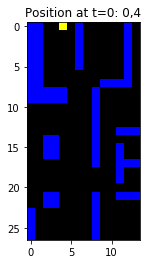

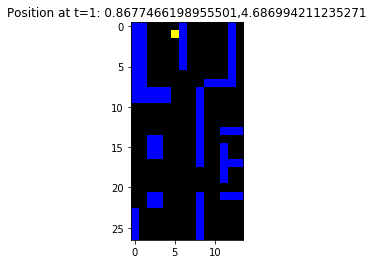

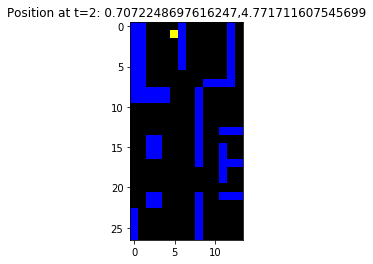

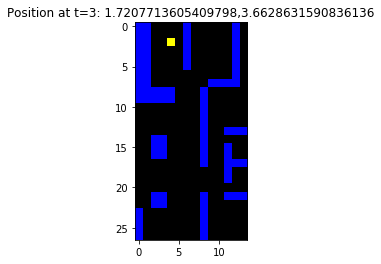

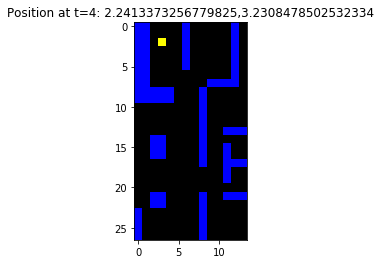

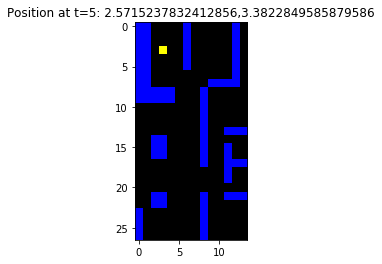

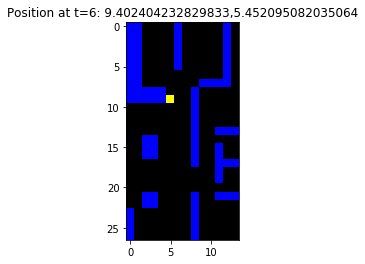

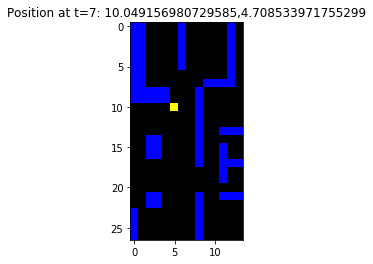

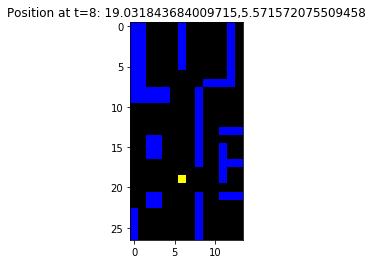

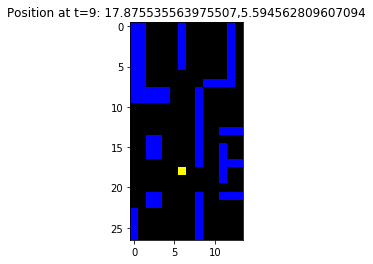

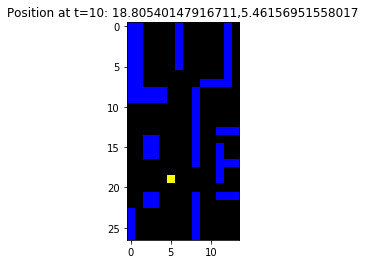

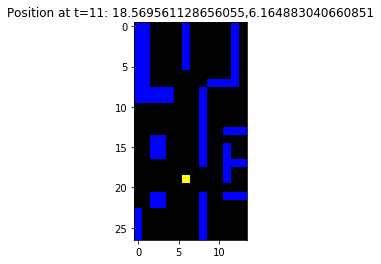

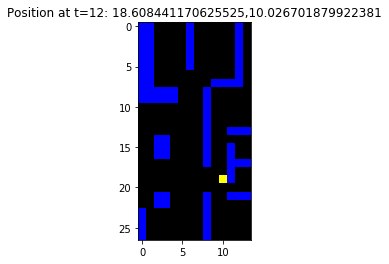

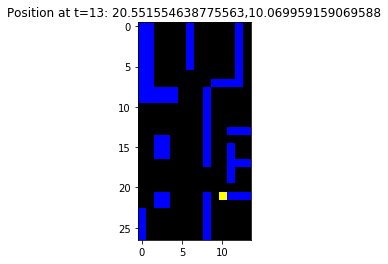

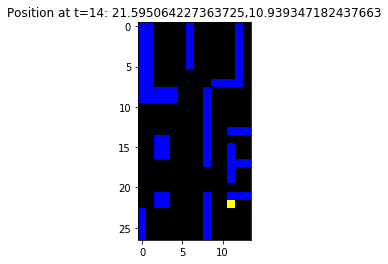

In [10]:
# new_map_ = deepcopy(map_)
# new_map_c = np.zeros((map_.shape[0],map_.shape[1],3))
# new_map_c[:,:,2] = new_map_ 
for i in range(len(position_history)): 
    new_map_ = deepcopy(map_)
    new_map_c = np.zeros((map_.shape[0],map_.shape[1],3))
    new_map_c[:,:,2] = new_map_ 
    x,y = position_history[i]
    print(x,y)
#     if y < 0:
#         y=y%14
#     if x < 0:
#         x=x%27
#     new_map_c[int(x%27), int(y%14),0] = 1.
#     new_map_c[int(x%27), int(y%14),1] = 1.   
    new_map_c[int(np.clip(np.around(x),0,27)), int(np.clip(np.around(y),0,14)),0] = 1.
    new_map_c[int(np.clip(np.around(x),0,27)), int(np.clip(np.around(y),0,14)),1] = 1.   
    plt.figure(); plt.imshow(new_map_c);plt.title("Position at t={}: {},{}"
                                                  .format(i,position_history[i][0],position_history[i][1]))

In [89]:
## NOTES: 
## -> after changing the center to the new it should really be resmapling the weights or be  
###### calculating the position of the user through the mean since the weightage will give the wrong 
######## results 